In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(plyr))
suppressMessages(library(cowplot))
suppressMessages(library(data.table))

suppressMessages(source("~/scripts/functions.R"))

setwd("/frazer01/home/jennifer/jn_projects/ppc_pilot")

In [2]:
load("manuscript/ppc_filt2.robj", verbose = T)

Loading objects:
  ppc2


In [17]:
load("/frazer01/home/jennifer/jn_projects/ppc_pilot/reference/scb_aggr.robj", verbose = T)

Loading objects:
  melton


# Z-score function

In [10]:
get_Zscores = function(meta, data, col, clusters, genes) {
    
    toplot = as.data.frame(rbindlist(lapply(genes, function(g){
    
        out = as.data.frame(rbindlist(lapply(clusters, function(c){

            cells = rownames(meta[meta[,col] == c,])
            exp_thresh = max(data[g,cells]) * 0.01
            ncells_passed = data[g,cells][which(data[g,cells] > exp_thresh)]
            avg_exp = mean(ncells_passed)
            data.frame(cluster = c, gene = g, avg_exp = avg_exp, pct_exp = length(ncells_passed) / length(cells) * 100)
            
        })))

        out$avg_exp = ifelse(is.na(out$avg_exp) == T, 0.0001, out$avg_exp)
        zavg = mean(out$avg_exp,  na.rm = T)
        zsd = sd(out$avg_exp,  na.rm = T)
        out$znorm_exp = (out$avg_exp - zavg) / zsd
        return(out)
    })))
    
    return(toplot)
}

# Get z-score

In [18]:
DefaultAssay(ppc2) = "RNA"

meta       = ppc2@meta.data
data       = GetAssayData(ppc2)
col        = "integrated_snn_res.0.08"
clusters   = unique(ppc2@meta.data[,col])

message(paste("# genes:", nrow(data)))

# genes: 62492



In [22]:
genes = unique(c("POU5F1", "COL1A1", "COL1A2", 
          "TP63", "AFP", "APOA2", "GATA4", 
          "GATA6", "PDX1", "NKX6-1", 
          "PAX6", "CHGA", "INS", "GCG", "SST", 
          "FLT1", "TOP2A", "CENPF", "AURKB", 
          "SOX17", "CXCR4", "SOX9",  "PTF1A",
          "TFAP2A", "TFAP2B", "GATA4", "GATA6", "HNF4A",
          "FOXA1", "FOXA2", "HES1", "SOX4", "SOX9",
          "SOX10", "SOX13", "PAX6", "PAX4",
          "RFX1", "RFX3", "HNF1A", "MAFA", "NKX2-2",
          "ETV1", "ETS1", "ETS2", "NEUROD1"))

genes = unique(c(genes, "TFAP2A", "TFAP2B",
                 "GRHL1", "GRHL2",
                 "GATA4", "GATA6", 
                 "PDX1", "NKX6-1", "HNF1A", 
                  "HNF1B", "CDX4", "CDX1", "MEIS2", 
                  "FOS", "JUN", "BACH2",
                 "HES1", "FOXA1", "FOXA2", "SOX4", "SOX10",
                  "PAX6", "PAX4", "RFX1", "RFX3", "HNF1A-AS1", "MAFA", "NKX2-2", "NEUROD1", "CTCF",
                 "ETV1", "ETS1", "ETS2", "FOS"))


In [23]:
ppc.toplot = get_Zscores(meta, data, col, clusters, genes)

In [21]:
meta     = melton@meta.data
data     = GetAssayData(melton)
clusters = unique(melton@meta.data[,"label"])
clusters = clusters[which(clusters %like% "FOXJ1" == F & 
                          clusters %like% "Replicating Stage 5" == F & 
                          clusters %like% "Replicating Stage 6" == F & 
                          clusters %like% "SST_HHEX" == F & 
                          clusters %like% "SST-HHEX" == F & 
                          clusters %like% "Fev" == F & 
                          clusters %like% "Neuro" == F)]

scb.toplot = get_Zscores(meta, data, "label", clusters, genes[which(genes %in% rownames(data))])


In [22]:
merged = rbind(ppc.toplot %>% mutate(study = "ppc"), scb.toplot %>% mutate(study = "melton"))

str(merged)

# fwrite(merged, "manuscript/Table_HeatmapZscore_scRNA.txt", row.names = F, sep = "\t")

'data.frame':	1061 obs. of  6 variables:
 $ cluster  : Factor w/ 21 levels "0","1","2","3",..: 5 2 3 1 6 4 7 8 5 2 ...
 $ gene     : chr  "POU5F1" "POU5F1" "POU5F1" "POU5F1" ...
 $ avg_exp  : num  0.616 0.52 2.499 0.743 0.372 ...
 $ pct_exp  : num  0.2523 0.0822 99.3574 0.071 0.201 ...
 $ znorm_exp: num  -0.2174 -0.3467 2.3212 -0.0462 -0.5453 ...
 $ study    : chr  "ppc" "ppc" "ppc" "ppc" ...


In [52]:
ppc.toplot %>% filter(gene %like% "GATA6") %>% arrange(desc(znorm_exp))

cluster,gene,avg_exp,pct_exp,znorm_exp
<fct>,<chr>,<dbl>,<dbl>,<dbl>
0,GATA6,1.0779896,41.53370582,1.4773299
3,GATA6,0.9833348,52.54111994,0.8065201
6,GATA6,0.9473311,28.18086225,0.5513656
1,GATA6,0.9395147,52.23826055,0.4959718
7,GATA6,0.8426659,21.42857143,-0.1903860
5,GATA6,0.7770801,59.44723618,-0.6551866
4,GATA6,0.7190824,19.19724771,-1.0662103
2,GATA6,0.6692448,0.04943154,-1.4194044


# Plot

In [48]:
table(ppc2@meta.data$cell, ppc2@meta.data$integrated_snn_res.0.08)

               
                    0     1     2     3     4     5     6     7
  Early DE          0     0     0     0     0  1990     0     0
  Early Ductal      0     0     0     0     0     0     0   392
  Early PPC         0     0     0  5411     0     0     0     0
  Endocrine         0     0     0     0     0     0   951     0
  iPSC              0     0  8092     0     0     0     0     0
  Late PPC      52083     0     0     0     0     0     0     0
  Mesendoderm       0     0     0     0  4360     0     0     0
  Rep. Late PPC     0 10946     0     0     0     0     0     0

In [49]:
DimPlot(ppc2, group.by = "integrated_snn_res.0.08", label = T, label.size = 7)

ERROR: Error in `[[<-`(`*tmp*`, "ident", value = Idents(object = object)): [[<- defined for objects of type "S4" only for subclasses of environment


In [59]:
cellmap = data.frame(cluster  = c(0:7),
                     rna.cell = c("Late PPC", "Rep. Late PPC", "iPSC", "Early PPC", "Mesendoderm", "Early DE", "Endocrine", "Early Ductal"),
                     color = c("#1B9E77", "#5fb189", "#7570B3", "#bbd2a6", "#E7298A", "#E6AB02", "#A6761D", "#666666"))

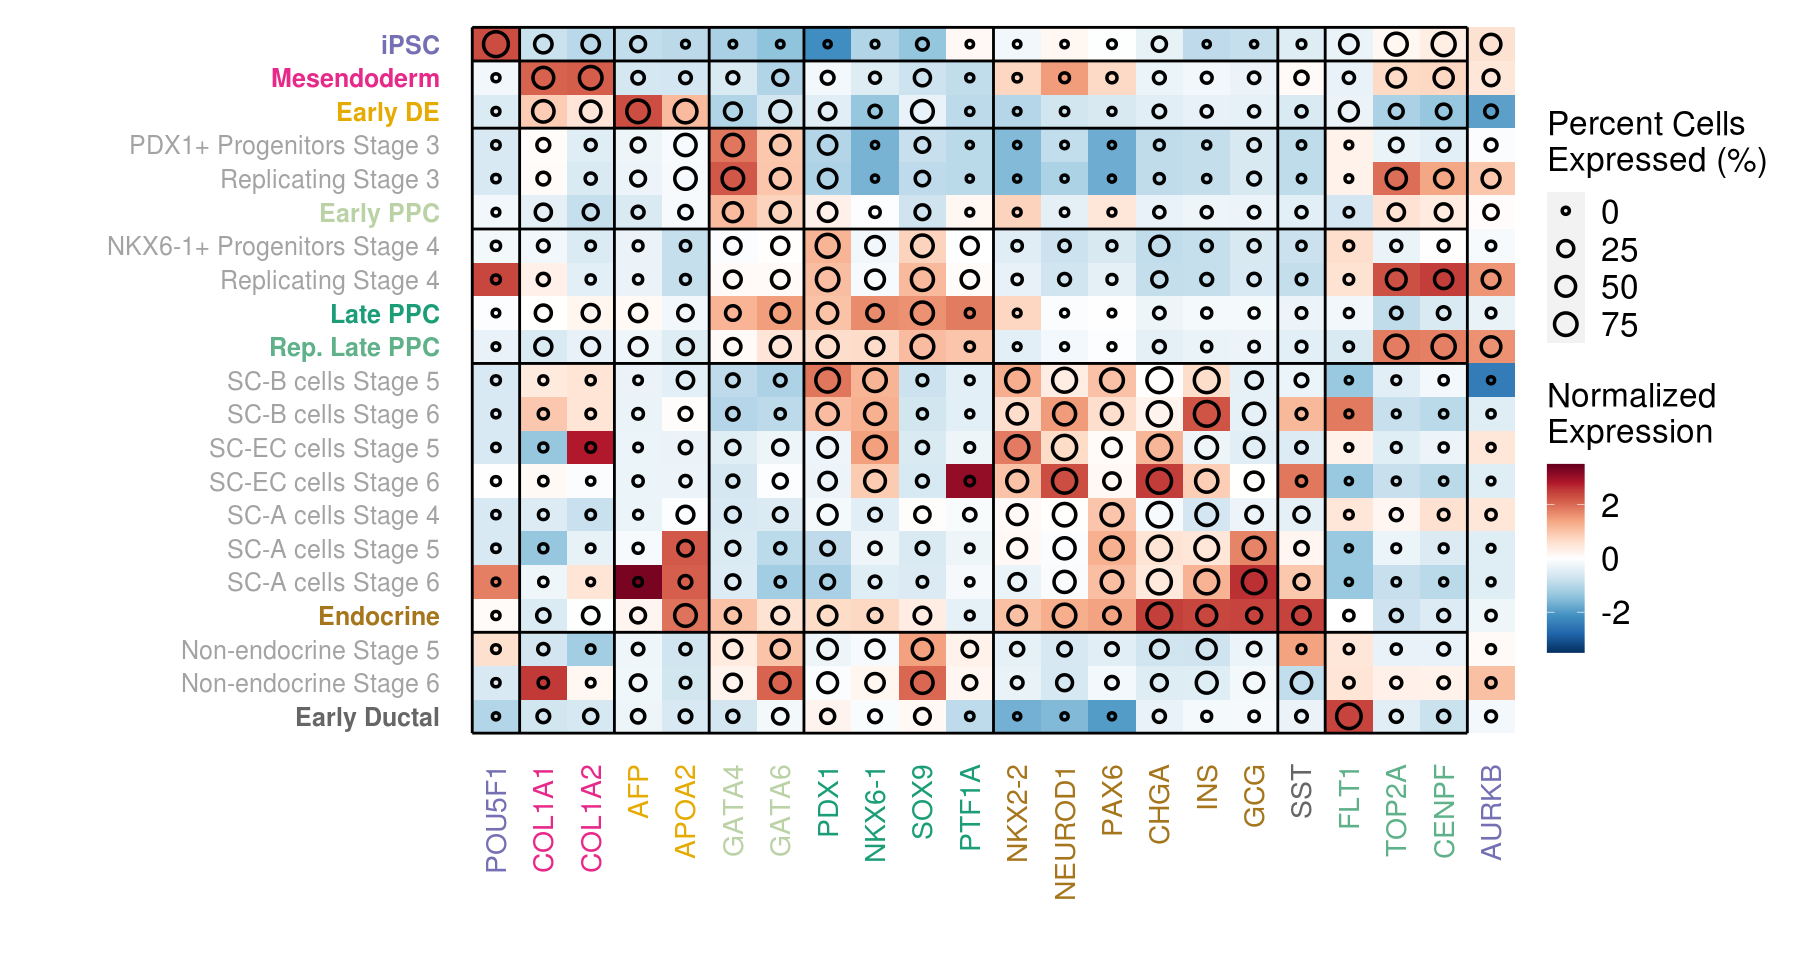

In [76]:
col2 = rev(c("#67001F", "#B2182B", "#D6604D", "#F4A582", "#FDDBC7", "#FFFFFF", "#D1E5F0", "#92C5DE", "#4393C3", "#2166AC", "#053061"))

genes_rna      = c("POU5F1", "COL1A1", "COL1A2",  "AFP", "APOA2", "GATA4", "GATA6", "PDX1", "NKX6-1", "SOX9", "PTF1A", "NKX2-2", "NEUROD1", 
                   "PAX6", "CHGA", "INS", "GCG", "SST", "FLT1", "TOP2A", "CENPF", "AURKB")

cluster.order = rev(c("iPSC", 
                   "Mesendoderm", 
                   "Early DE", 
                   "PDX1+ Progenitors Stage 3",
                   "Replicating Stage 3",
                   "Early PPC", 
                   "NKX6-1+ Progenitors Stage 4",
                   "Replicating Stage 4",
                   "Late PPC",
                   "Rep. Late PPC",
                   paste("SC-B cells" , "Stage", c(5:6)),
                   paste("SC-EC cells", "Stage", c(5:6)),
                   paste("SC-A cells" , "Stage", c(4:6)),
                   "Endocrine",
                   "Non-endocrine Stage 5",
                   "Non-endocrine Stage 6",
                   "Early Ductal"))

toplot         = merged[merged$gene %in% genes_rna,]
toplot$cluster = as.vector(toplot$cluster)
toplot$gene    = factor(toplot$gene, levels = genes_rna)
toplot$cluster = unlist(lapply(toplot$cluster, function(x) { suppressMessages(mapvalues(x, from = cellmap$cluster, to = cellmap$rna.cell))}))
toplot$cluster = factor(toplot$cluster, levels = cluster.order)

axis.cols = suppressMessages(mapvalues(cluster.order, from = cellmap$rna.cell, to = cellmap$color))
axis.cols = ifelse(axis.cols %like% "#", axis.cols, "#a3a3a3")

x.axis.cols = c(rep("#7570B3", 1), rep("#E7298A", 2), rep("#E6AB02", 2), rep("#bbd2a6", 2), rep("#1B9E77", 4), rep("#A6761D", 6), rep("#666666", 1), rep("#5fb189", 3))

options(repr.plot.height = 7, repr.plot.width = 15)
p = ggplot(toplot, aes(x = gene, y = cluster, fill = znorm_exp)) + geom_tile() + jn_theme +
        scale_fill_gradientn(colors = col2, 
                             name = "Normalized\nExpression", 
                             limits = c(-3.5, 3.5), 
                             guide = guide_colorbar(frame.color = "black", ticks.color = "black"))  +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, color = x.axis.cols, vjust = 0.5,  size = 17),
              axis.text.y = element_text(face = ifelse(cluster.order %like% "Stage", "plain", "bold"), color = axis.cols, size = 15),
              axis.ticks  = element_blank(),
              panel.border = element_blank(),
              legend.key.size = unit(0.8, "cm")
             ) +
        geom_point(data = toplot, aes(x = gene, y = cluster, size = pct_exp), stroke = 1.5, shape = 1) +
        xlab("") + ylab("") + guides(size = guide_legend("Percent Cells\nExpressed (%)"))

hlines = c(0.5, 3.5, 11.5, 15.5, 18.5, 20.5, 21.5)
for (h in hlines) {
    p = p + annotate("segment", x = 0.5, xend = 21.5, y = h, yend = h, size = 0.8)
}

vlines = c(0.5, 1.5, 3.5, 5.5, 7.5, 11.5, 17.5, 18.5, 21.5)
for (v in vlines) {p = p + annotate("segment", x = v, xend = v, y = 0.5, yend = 21.5, size = 0.8) }

rna_heat = p

psize(w = 15, h = 8)
rna_heat

# save(rna_heat, file = paste("manuscript", "rna_heat.robj", sep = "/"))


In [24]:
load(paste("manuscript", "rna_heat.robj", sep = "/"), verbose = T)

Loading objects:
  rna_heat


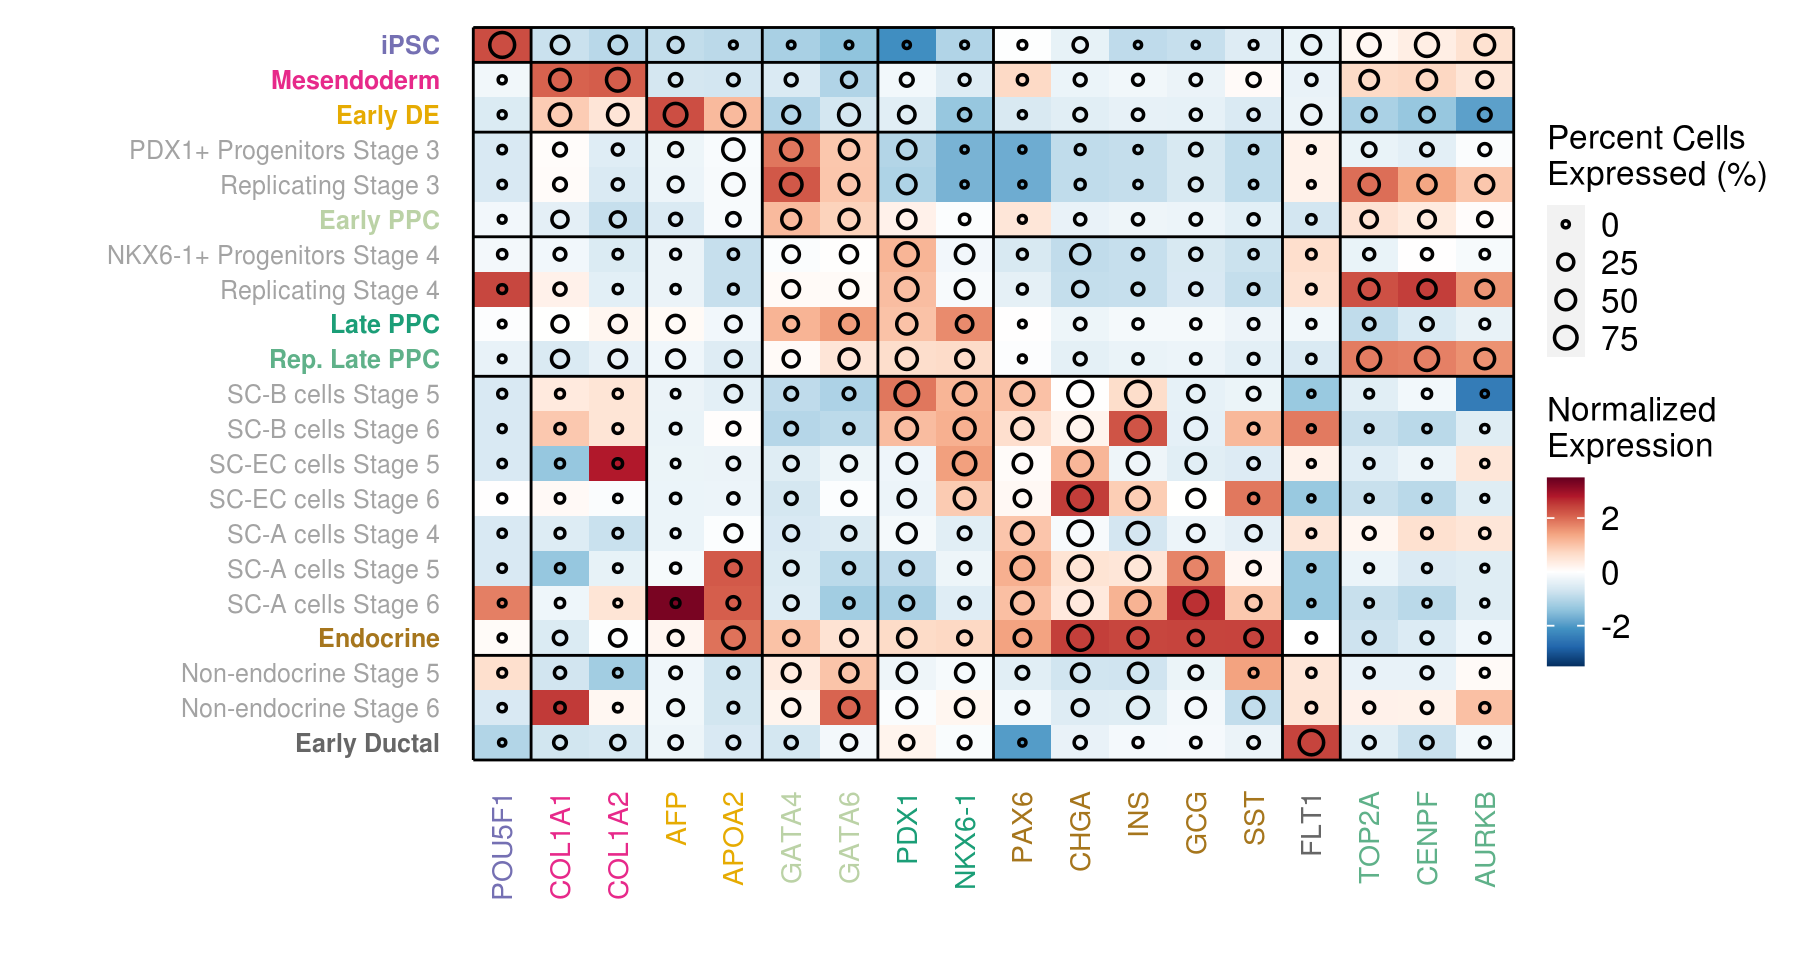

In [26]:
psize(w = 15, h = 8)
rna_heat

# Violin Plot

In [32]:
genes_rna      = c("POU5F1", "COL1A1", "COL1A2",  "AFP", "APOA2", "GATA4", "GATA6", "PDX1", "NKX6-1", 
                   "PAX6", "CHGA", "INS", "GCG", "SST", "FLT1", "TOP2A", "CENPF", "AURKB")

In [33]:
data = GetAssayData(ppc2, "data")
meta = ppc2@meta.data

plotlist=  list()

data_summary <- function(x) {
   m <- mean(x)
   ymin <- m-sd(x)
   ymax <- m+sd(x)
   return(c(y=m,ymin=ymin,ymax=ymax))
}

for (gene in genes_rna){
    toplot         = data.frame(exp = data[gene,], cells = colnames(data))
    toplot$cluster = as.numeric(suppressMessages(mapvalues(toplot$cells, from = rownames(meta), to = meta$integrated_snn_res.0.08)))
    toplot$cluster = toplot$cluster - 1
    toplot$cell    = suppressMessages(mapvalues(toplot$cluster, from = cellmap$cluster, cellmap$rna.cell))
    
    cell_order  = c("iPSC", "Mesendoderm", "Early DE", "Early PPC", "Late PPC", "Rep. Late PPC", "Endocrine", "Early Ductal")
    col_order   = suppressMessages(mapvalues(cell_order, from = cellmap$rna.cell, to = cellmap$color))
    toplot$cell = factor(toplot$cell, levels = cell_order)

    options(repr.plot.height= 8 , repr.plot.width = 15)
    p = ggplot(toplot, aes(x = cell, y = exp, fill = cell)) + geom_violin(scale = "width") + jn_theme + 
         ylab("Normalized Expression") + xlab("") + scale_fill_manual(values = col_order) + 
        theme(legend.position = "none", axis.text.x = element_text(colour = col_order), 
              panel.border = element_blank(), axis.line.y = element_line(color = "black"),
              axis.ticks.x = element_blank(), plot.title = element_text(hjust = 0.5, size = 30),
              axis.text = element_text(size = 25), axis.title = element_text(size = 25)) + ggtitle(gene) +
        stat_summary(fun.data=data_summary) + 
        scale_x_discrete(labels = c("iPSC", "Mes.", "Early\nDE", "Early\nPPC", "Late\nPPC", "Rep.\nLate\nPPC", "Endo.", "Early\nDuctal"))
    
    plotlist[[gene]] = p
}



png 
  2

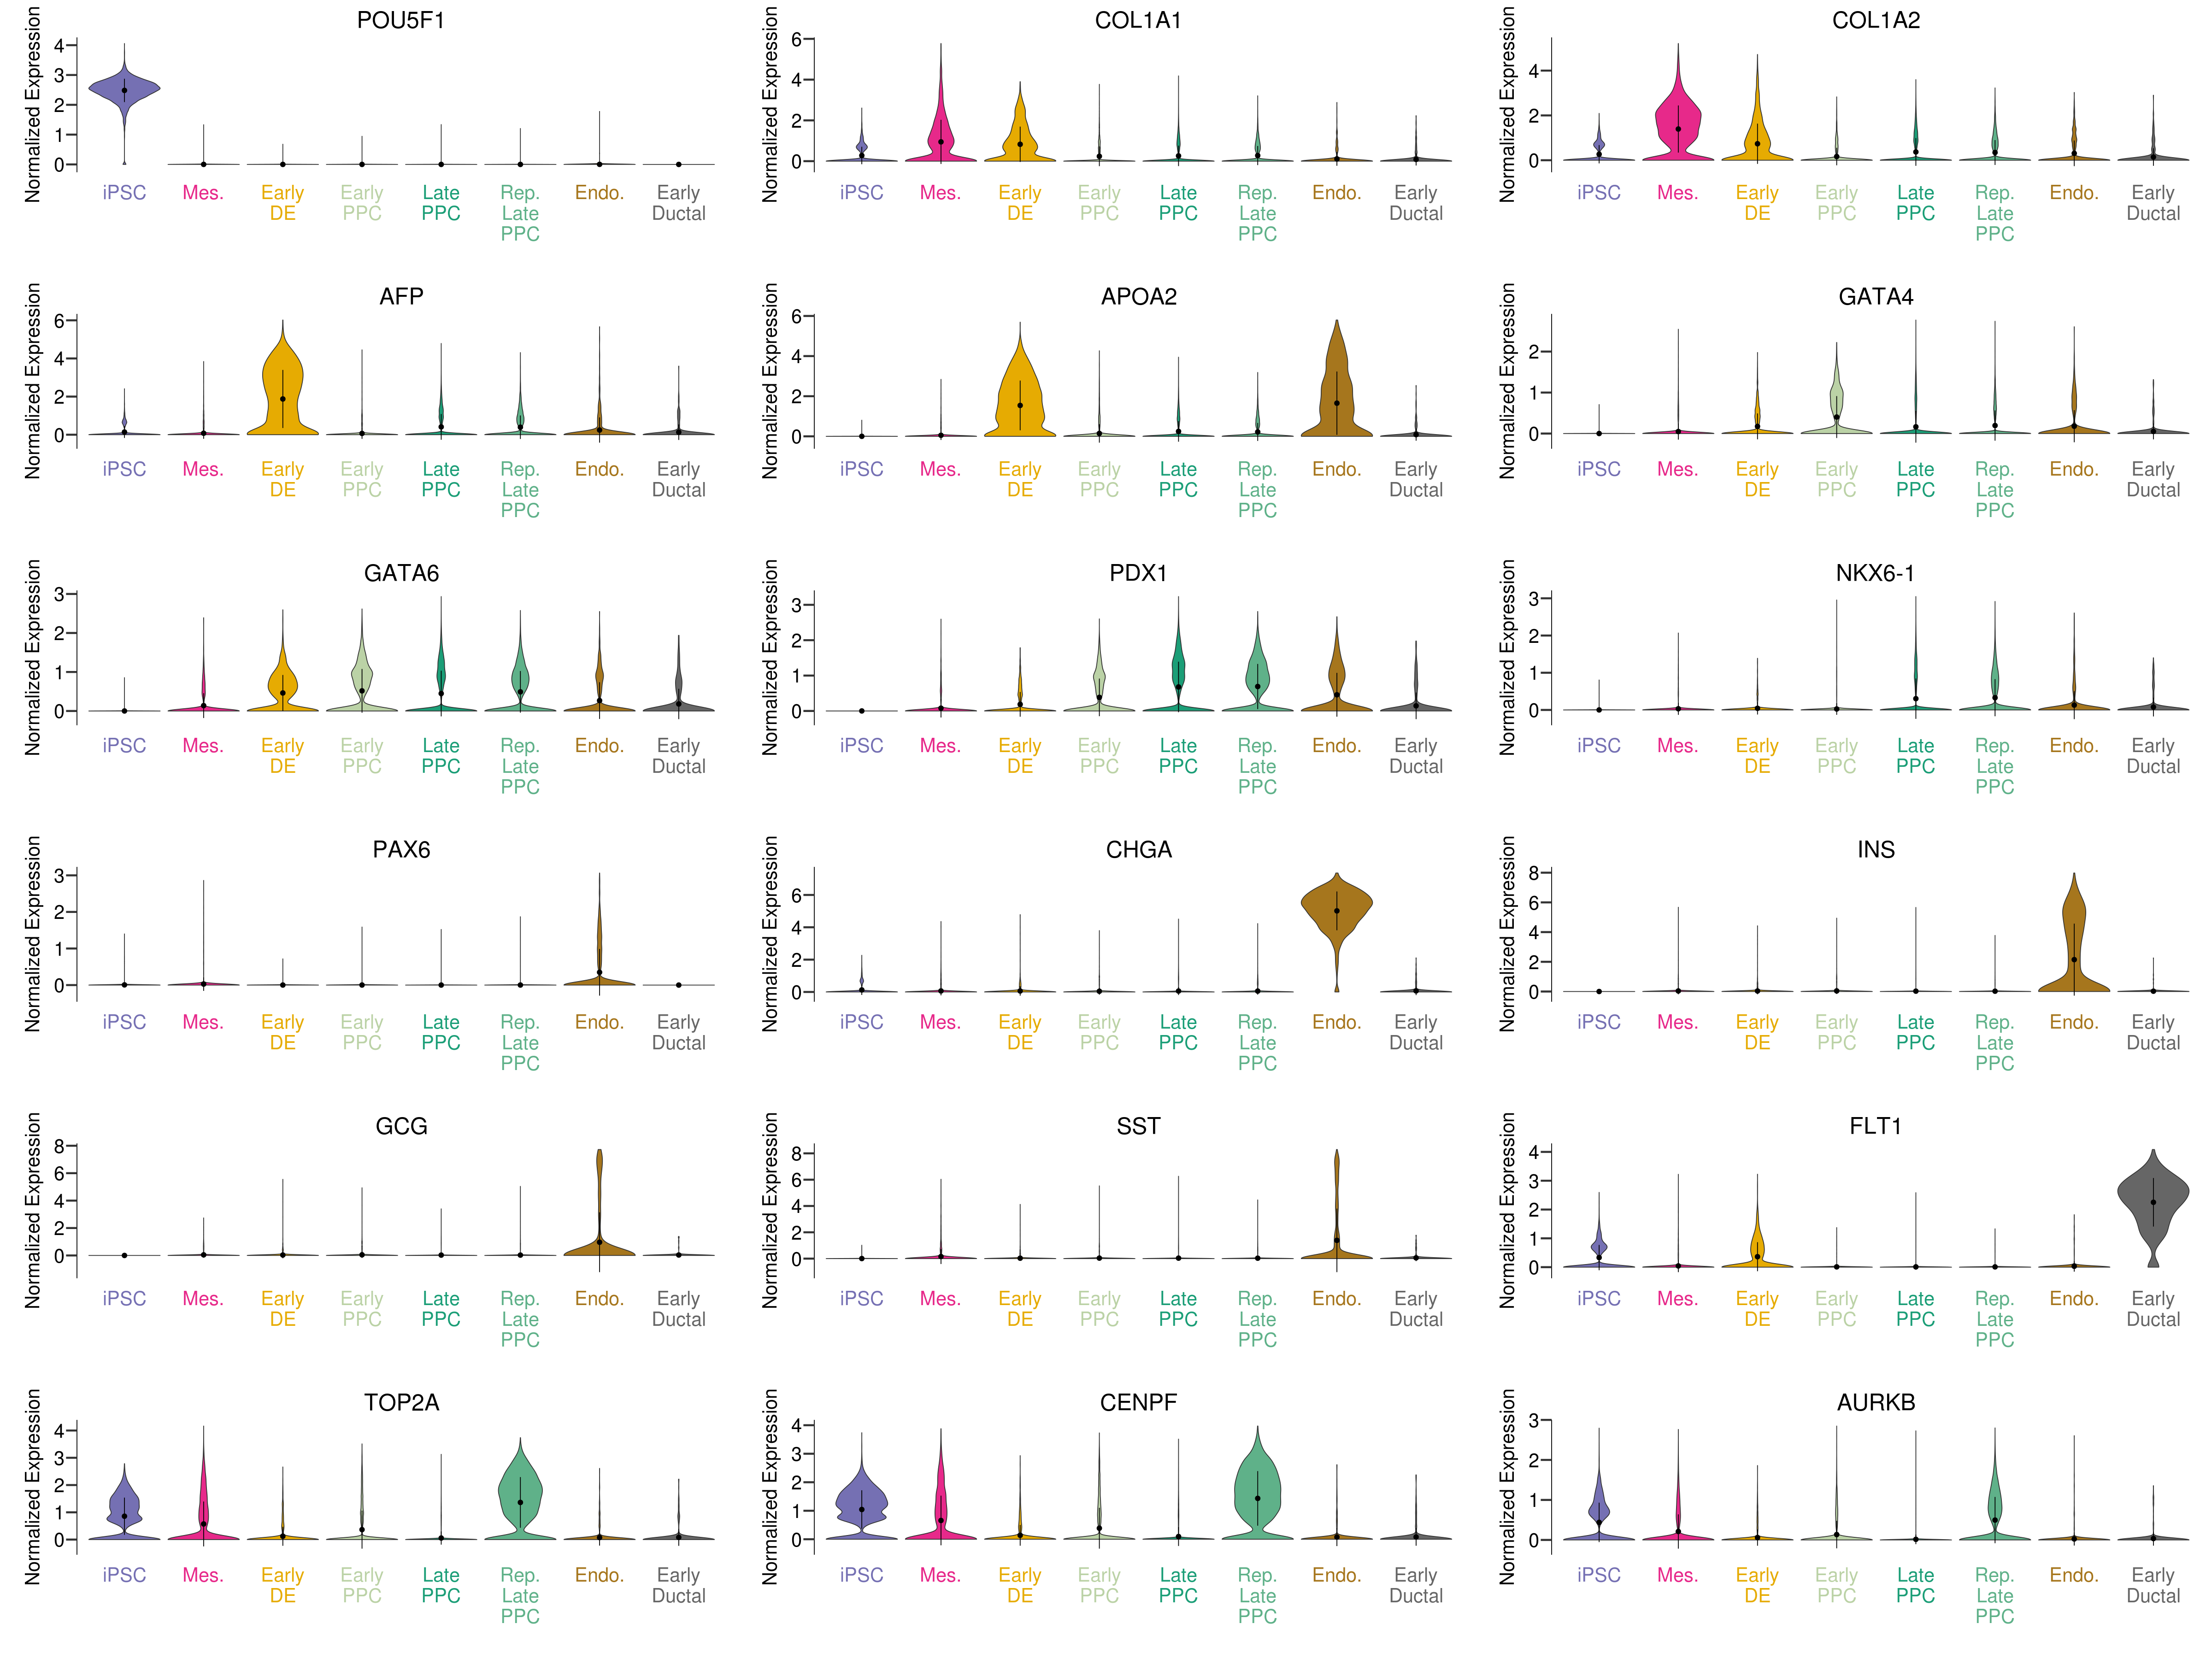

In [34]:
library(cowplot)
options(repr.plot.width = 40, repr.plot.height = 30)
png(paste("manuscript/violin_plots.png"), width = 3200, height = 2500)
plot_grid(plotlist = plotlist, ncol = 3)
dev.off()

plot_grid(plotlist = plotlist, ncol = 3)

# Different Resolution

In [116]:
umaps = list()

umaps[["res 0.05"]] = DimPlot(ppc2, group.by = "integrated_snn_res.0.05", label = T, label.size = 7) + ggtitle("Resolution 0.05") + theme(legend.position = "none", plot.title = element_text(size = 22), axis.text = element_text(size = 15))
umaps[["res 0.1"]] = DimPlot(ppc2, group.by = "integrated_snn_res.0.1", label = T, label.size = 7) + ggtitle("Resolution 0.1") + theme(legend.position = "none", plot.title = element_text(size = 22), , axis.text = element_text(size = 15))



In [79]:
DefaultAssay(ppc2) = "RNA"

meta       = ppc2@meta.data
data       = GetAssayData(ppc2)
col        = "integrated_snn_res.0.05"
clusters   = unique(ppc2@meta.data[,col])

message(paste("# genes:", nrow(data)))

ppc.toplot = get_Zscores(meta, data, col, clusters, genes)

meta     = melton@meta.data
data     = GetAssayData(melton)
clusters = unique(melton@meta.data[,"label"])
clusters = clusters[which(clusters %like% "FOXJ1" == F & 
                          clusters %like% "Replicating Stage 5" == F & 
                          clusters %like% "Replicating Stage 6" == F & 
                          clusters %like% "SST_HHEX" == F & 
                          clusters %like% "SST-HHEX" == F & 
                          clusters %like% "Fev" == F & 
                          clusters %like% "Neuro" == F)]

scb.toplot = get_Zscores(meta, data, "label", clusters, genes[which(genes %in% rownames(data))])

merged = rbind(ppc.toplot %>% mutate(study = "ppc"), scb.toplot %>% mutate(study = "melton"))

str(merged)

fwrite(merged, "manuscript/Table_HeatmapZscore_scRNA_res0.05.txt", row.names = F, sep = "\t")

# genes: 62492



'data.frame':	787 obs. of  6 variables:
 $ cluster  : Factor w/ 20 levels "0","1","2","3",..: 1 2 4 5 6 7 3 1 2 4 ...
 $ gene     : chr  "POU5F1" "POU5F1" "POU5F1" "POU5F1" ...
 $ avg_exp  : num  0.706 0.52 0.626 0.616 0.84 ...
 $ pct_exp  : num  0.0758 0.0824 0.1297 0.2523 0.3155 ...
 $ znorm_exp: num  -0.1572 -0.3959 -0.2607 -0.2734 0.0136 ...
 $ study    : chr  "ppc" "ppc" "ppc" "ppc" ...


In [80]:
DefaultAssay(ppc2) = "RNA"

meta       = ppc2@meta.data
data       = GetAssayData(ppc2)
col        = "integrated_snn_res.0.1"
clusters   = unique(ppc2@meta.data[,col])

message(paste("# genes:", nrow(data)))

ppc.toplot = get_Zscores(meta, data, col, clusters, genes)

meta     = melton@meta.data
data     = GetAssayData(melton)
clusters = unique(melton@meta.data[,"label"])
clusters = clusters[which(clusters %like% "FOXJ1" == F & 
                          clusters %like% "Replicating Stage 5" == F & 
                          clusters %like% "Replicating Stage 6" == F & 
                          clusters %like% "SST_HHEX" == F & 
                          clusters %like% "SST-HHEX" == F & 
                          clusters %like% "Fev" == F & 
                          clusters %like% "Neuro" == F)]

scb.toplot = get_Zscores(meta, data, "label", clusters, genes[which(genes %in% rownames(data))])

merged = rbind(ppc.toplot %>% mutate(study = "ppc"), scb.toplot %>% mutate(study = "melton"))

str(merged)

fwrite(merged, "manuscript/Table_HeatmapZscore_scRNA_res0.1.txt", row.names = F, sep = "\t")

# genes: 62492



'data.frame':	907 obs. of  6 variables:
 $ cluster  : Factor w/ 23 levels "0","1","2","3",..: 1 2 3 5 6 7 8 10 9 4 ...
 $ gene     : chr  "POU5F1" "POU5F1" "POU5F1" "POU5F1" ...
 $ avg_exp  : num  0.702 0.774 0.52 0.626 0.652 ...
 $ pct_exp  : num  0.0425 0.1449 0.084 0.1292 0.2418 ...
 $ znorm_exp: num  -0.0331 0.0742 -0.3028 -0.1458 -0.107 ...
 $ study    : chr  "ppc" "ppc" "ppc" "ppc" ...


In [94]:
heats = list()

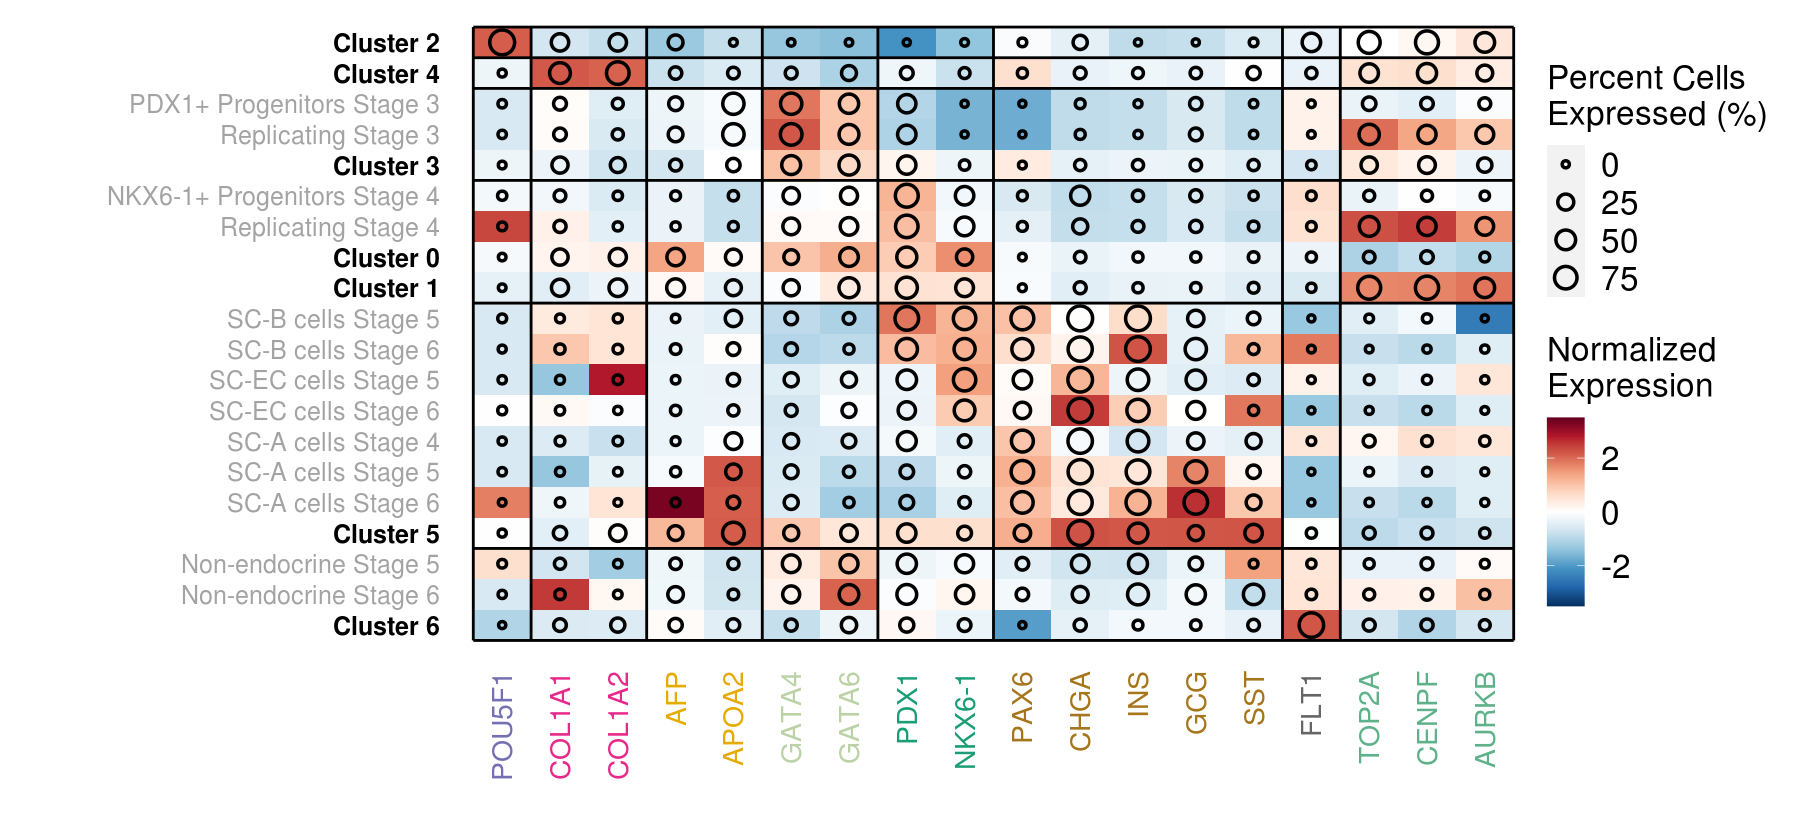

In [96]:
merged = fread("manuscript/Table_HeatmapZscore_scRNA_res0.05.txt", data.table = F)

cluster.order = rev(c("Cluster 2", 
                   "Cluster 4", 
                   "PDX1+ Progenitors Stage 3",
                   "Replicating Stage 3",
                   "Cluster 3", 
                   "NKX6-1+ Progenitors Stage 4",
                   "Replicating Stage 4",
                   "Cluster 0",
                   "Cluster 1",
                   paste("SC-B cells" , "Stage", c(5:6)),
                   paste("SC-EC cells", "Stage", c(5:6)),
                   paste("SC-A cells" , "Stage", c(4:6)),
                   "Cluster 5",
                   "Non-endocrine Stage 5",
                   "Non-endocrine Stage 6",
                   "Cluster 6"))

toplot         = merged[merged$gene %in% genes_rna,]
toplot$cluster = as.vector(toplot$cluster)
toplot$gene    = factor(toplot$gene, levels = genes_rna)
toplot$cluster = ifelse(toplot$cluster %in% as.character(c(0:6)), paste("Cluster", toplot$cluster), toplot$cluster)
toplot$cluster = factor(toplot$cluster, levels = cluster.order)

axis.cols = ifelse(cluster.order %like% "Cluster", "black", "#a3a3a3")

x.axis.cols = c(rep("#7570B3", 1), rep("#E7298A", 2), rep("#E6AB02", 2), rep("#bbd2a6", 2), rep("#1B9E77", 2), rep("#A6761D", 5), rep("#666666", 1), rep("#5fb189", 3))

options(repr.plot.height = 7, repr.plot.width = 15)
p = ggplot(toplot, aes(x = gene, y = cluster, fill = znorm_exp)) + geom_tile() + jn_theme +
        scale_fill_gradientn(colors = col2, 
                             name = "Normalized\nExpression", 
                             limits = c(-3.5, 3.5), 
                             guide = guide_colorbar(frame.color = "black", ticks.color = "black"))  +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, color = x.axis.cols, vjust = 0.5,  size = 17),
              axis.text.y = element_text(face = ifelse(cluster.order %like% "Stage", "plain", "bold"), color = axis.cols, size = 15),
              axis.ticks  = element_blank(),
              panel.border = element_blank(),
              legend.key.size = unit(0.8, "cm")
             ) +
        geom_point(data = toplot, aes(x = gene, y = cluster, size = pct_exp), stroke = 1.5, shape = 1) +
        xlab("") + ylab("") + guides(size = guide_legend("Percent Cells\nExpressed (%)"))

hlines = c(0.5, 3.5, 11.5, 15.5, 18.5, 19.5, 20.5)
for (h in hlines) {
    p = p + annotate("segment", x = 0.5, xend = 18.5, y = h, yend = h, size = 0.8)
}

vlines = c(0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 14.5, 15.5, 18.5)
for (v in vlines) {p = p + annotate("segment", x = v, xend = v, y = 0.5, yend = 20.5, size = 0.8) }

heats[["res 0.05"]] = p

p


[1] 3 9 5 6 4 0 1 2 7 8

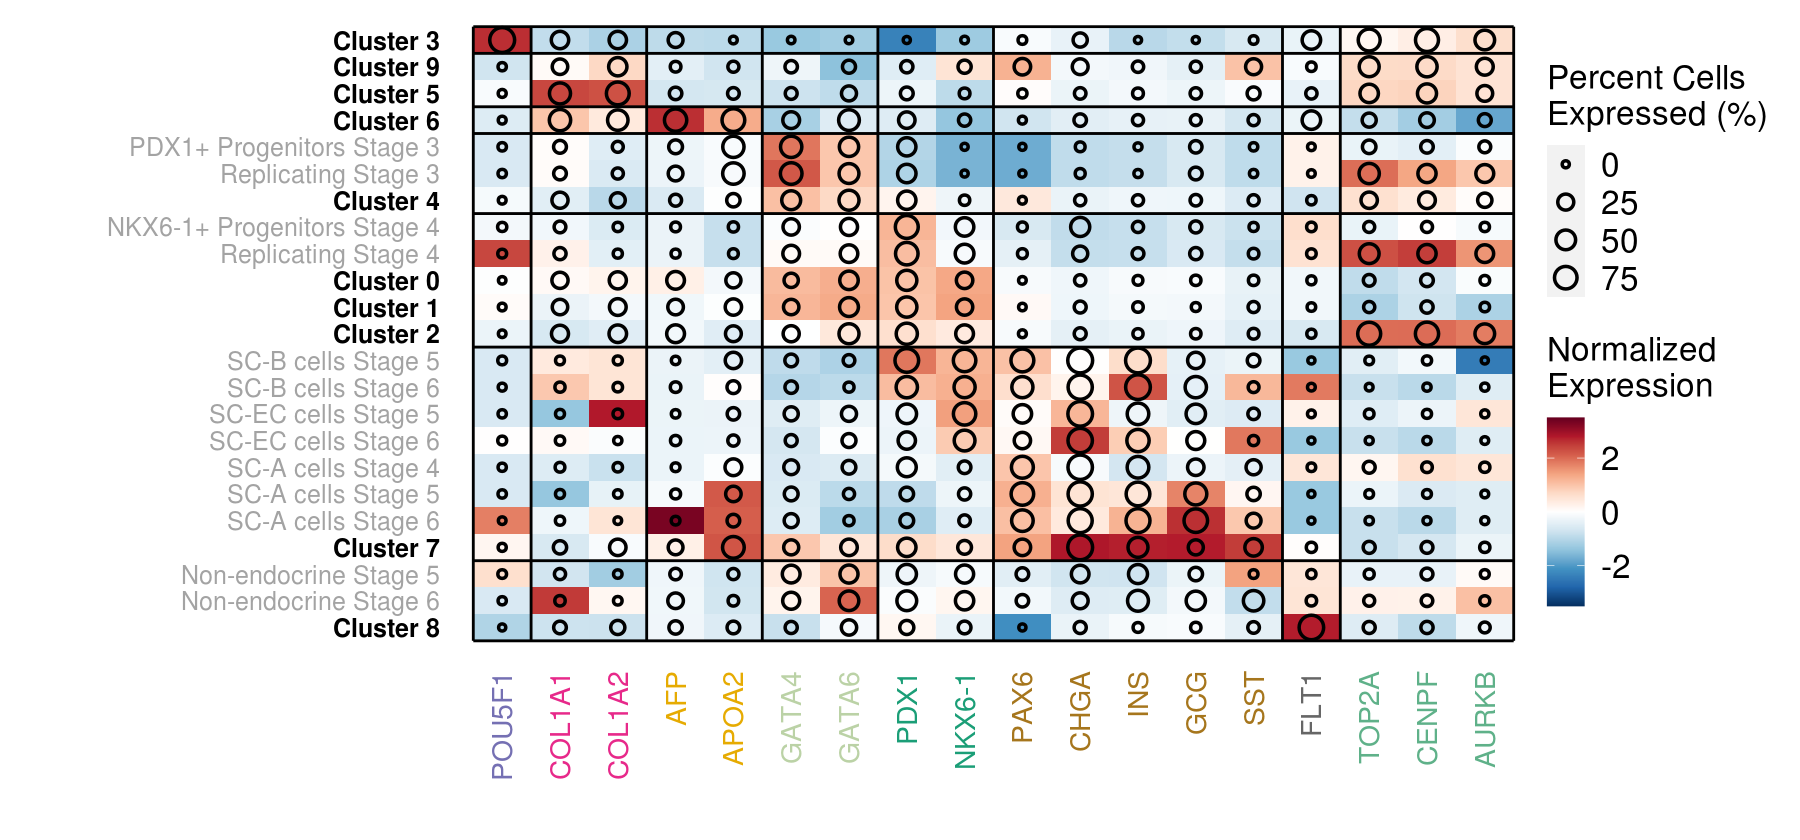

In [97]:
c(3, 9, 5, 6, 4, 0, 1, 2, 7, 8)

merged = fread("manuscript/Table_HeatmapZscore_scRNA_res0.1.txt", data.table = F)

cluster.order = rev(c("Cluster 3", 
                   "Cluster 9", 
                   "Cluster 5", 
                   "Cluster 6",
                   "PDX1+ Progenitors Stage 3",
                   "Replicating Stage 3",
                   "Cluster 4", 
                   "NKX6-1+ Progenitors Stage 4",
                   "Replicating Stage 4",
                   "Cluster 0",
                   "Cluster 1",
                   "Cluster 2",
                   paste("SC-B cells" , "Stage", c(5:6)),
                   paste("SC-EC cells", "Stage", c(5:6)),
                   paste("SC-A cells" , "Stage", c(4:6)),
                   "Cluster 7",
                   "Non-endocrine Stage 5",
                   "Non-endocrine Stage 6",
                   "Cluster 8"))

toplot         = merged[merged$gene %in% genes_rna,]
toplot$cluster = as.vector(toplot$cluster)
toplot$gene    = factor(toplot$gene, levels = genes_rna)
toplot$cluster = ifelse(toplot$cluster %in% as.character(c(0:9)), paste("Cluster", toplot$cluster), toplot$cluster)
toplot$cluster = factor(toplot$cluster, levels = cluster.order)

axis.cols = ifelse(cluster.order %like% "Cluster", "black", "#a3a3a3")

x.axis.cols = c(rep("#7570B3", 1), rep("#E7298A", 2), rep("#E6AB02", 2), rep("#bbd2a6", 2), rep("#1B9E77", 2), rep("#A6761D", 5), rep("#666666", 1), rep("#5fb189", 3))

options(repr.plot.height = 7, repr.plot.width = 15)
p = ggplot(toplot, aes(x = gene, y = cluster, fill = znorm_exp)) + geom_tile() + jn_theme +
        scale_fill_gradientn(colors = col2, 
                             name = "Normalized\nExpression", 
                             limits = c(-3.5, 3.5), 
                             guide = guide_colorbar(frame.color = "black", ticks.color = "black"))  +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, color = x.axis.cols, vjust = 0.5,  size = 17),
              axis.text.y = element_text(face = ifelse(cluster.order %like% "Stage", "plain", "bold"), color = axis.cols, size = 15),
              axis.ticks  = element_blank(),
              panel.border = element_blank(),
              legend.key.size = unit(0.8, "cm")
             ) +
        geom_point(data = toplot, aes(x = gene, y = cluster, size = pct_exp), stroke = 1.5, shape = 1) +
        xlab("") + ylab("") + guides(size = guide_legend("Percent Cells\nExpressed (%)"))

hlines = c(0.5, 3.5, 11.5, 16.5, 19.5, 20.5, 22.5, 23.5)
for (h in hlines) {
    p = p + annotate("segment", x = 0.5, xend = 18.5, y = h, yend = h, size = 0.8)
}

vlines = c(0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 14.5, 15.5, 18.5)
for (v in vlines) {p = p + annotate("segment", x = v, xend = v, y = 0.5, yend = 23.5, size = 0.8) }

heats[["res 0.1"]] = p

p


In [121]:
options(repr.plot.height = 7, repr.plot.width = 25)
g1 = plot_grid(umaps[["res 0.05"]], heats[["res 0.05"]], nrow = 1, labels = c("A", "B"), rel_widths = c(0.5, 1), label_size = 33)
g2 = plot_grid(umaps[["res 0.1"]], heats[["res 0.1"]], nrow = 1, labels = c("C", "D"), rel_widths = c(0.5, 1), label_size = 33)

g = plot_grid(g1, g2, ncol = 1)

png("manuscript/scRNA_res.png", width = 1500, height = 1000)
print(g)
dev.off()

png 
  2

# Bar

In [28]:
cellmap = data.frame(cluster  = c(0:7),
                     rna.cell = c("Late PPC", "Rep. Late PPC", "iPSC", "Early PPC", "Mesendoderm", "Early DE", "Endocrine", "Early Ductal"),
                     color = c("#1B9E77", "#5fb189", "#7570B3", "#bbd2a6", "#E7298A", "#E6AB02", "#A6761D", "#666666"))

In [80]:
sample_meta = fread(paste("pipeline/1.Metadata", "subject_sample_metadata.txt", sep = "/"), data.table = F)

ppc2@meta.data$pdx1_nkx61 = suppressMessages(mapvalues(ppc2@meta.data$udid, from = sample_meta$UDID, to = sample_meta[,"%PDX1+_NKX6.1+"]))
ppc2@meta.data$cell = as.vector(suppressMessages(mapvalues(ppc2@meta.data$integrated_snn_res.0.08, from = cellmap$cluster, to = cellmap$rna.cell)))
ppc2@meta.data[ppc2@meta.data$udid == "PPC_034",]$pdx1_nkx61 = 71.2
ppc2@meta.data[ppc2@meta.data$udid %like% "iPSC",]$pdx1_nkx61 = NA


In [81]:
toplot = as.data.frame(rbindlist(lapply(unique(ppc2@meta.data$udid), function(udid){
    this = ppc2@meta.data[ppc2@meta.data$udid == udid,]
    as.data.frame(rbindlist(lapply(unique(ppc2@meta.data$integrated_snn_res.0.08), function(label){
        ncells = nrow(this[this$integrated_snn_res.0.08 == label,])
        data.frame(udid = udid, cluster = label, pct = ncells / nrow(this) * 100)
    })))
})))

toplot$cell = suppressMessages(mapvalues(toplot$cluster, from = cellmap$cluster, to = cellmap$rna.cell))
toplot$cluster = paste("Cluster", toplot$cluster)
# fwrite(toplot, "manuscript/udid.pct_cells.txt", row.names = F, sep = "\t")

udid,cluster,pct,cell
<fct>,<fct>,<dbl>,<fct>
PPC_028,Cluster 2,0.0000000,iPSC
PPC_028,Cluster 7,0.3239741,Early Ductal
PPC_028,Cluster 1,0.5553841,Rep. Late PPC
PPC_028,Cluster 6,1.3421783,Endocrine
PPC_028,Cluster 0,1.3576057,Late PPC
PPC_028,Cluster 5,2.4529466,Early DE
PPC_028,Cluster 4,32.7830916,Mesendoderm
PPC_028,Cluster 3,61.1848195,Early PPC


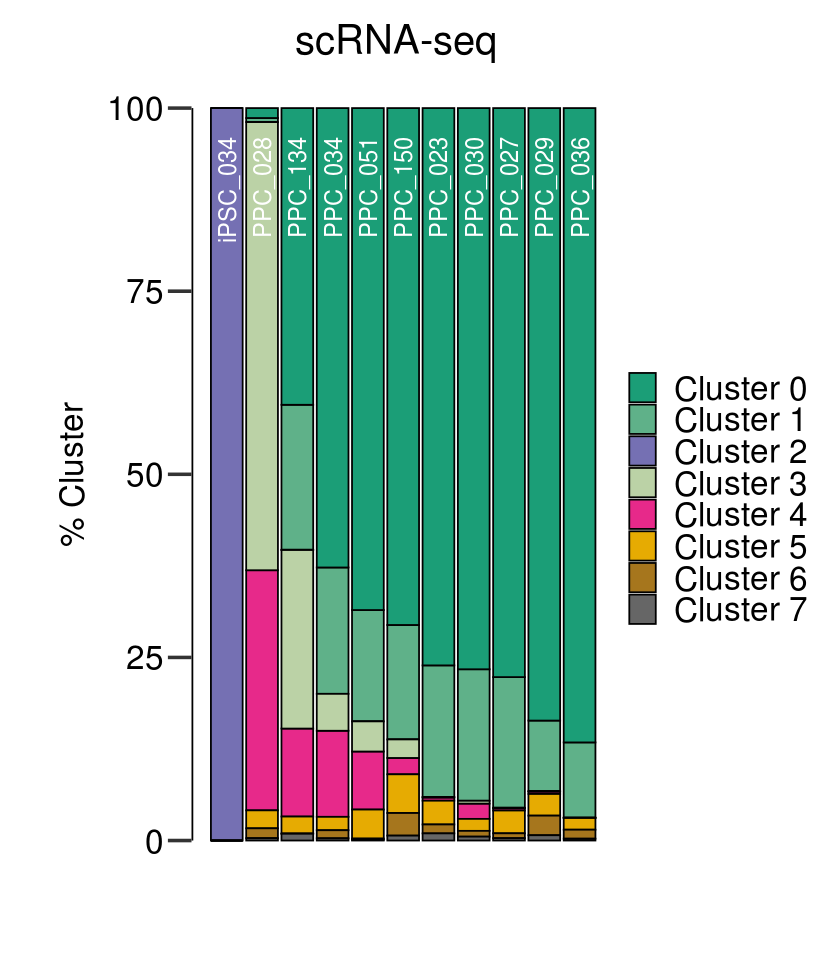

In [87]:
cluster.order  = paste("Cluster", c(0:7))
toplot$cluster = factor(toplot$cluster, levels = cluster.order)

col.order      = suppressMessages(mapvalues(cluster.order, from = paste("Cluster", cellmap$cluster), to = cellmap$color))
udid.order     = (toplot[toplot$cluster %like% "Cluster 0",] %>% arrange(pct))$udid
toplot$udid    = factor(toplot$udid, levels = unique(udid.order))

toplot %>% filter(udid == "PPC_028") %>% arrange(pct)

p = ggplot(toplot, aes(x = udid, y = pct, fill = cluster)) + geom_bar(stat = "identity", color = "black") + 
    scale_fill_manual(values = col.order, name = "") + jn_theme + theme(axis.text.x = element_blank()) + 
    xlab("") + ylab("% Cluster") +
    theme(panel.border = element_blank(), axis.ticks.x = element_blank(), plot.title = element_text(hjust = 0.5)) + 
    annotate("text", x = 1, y = 96, label = "iPSC_034", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 2, y = 96, label = "PPC_028", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 3, y = 96, label = "PPC_134", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 4, y = 96, label = "PPC_034", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 5, y = 96, label = "PPC_051", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 6, y = 96, label = "PPC_150", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 7, y = 96, label = "PPC_023", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 8, y = 96, label = "PPC_030", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 9, y = 96, label = "PPC_027", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 10, y = 96, label = "PPC_029", angle = 90, hjust = 1, size = 5, color = "#ffffff") +
    annotate("text", x = 11, y = 96, label = "PPC_036", angle = 90, hjust = 1, size = 5, color = "#ffffff") + 
    annotate("segment", x = 0, xend = 0, y = 0, yend = 100, size = 1) + 
    theme(axis.ticks.y = element_line(size = 1)) + ggtitle("scRNA-seq")

p

rna.bar = p

save(rna.bar, file = paste("manuscript", "rna_bar.robj", sep = "/"))

In [144]:
sample_meta = fread(paste("pipeline", "1.Metadata", "subject_sample_metadata.txt", sep = "/"), data.table = F)
sample_meta[sample_meta$UDID == "PPC_134", "%PDX1+_NKX6.1+"] = 14.6
sample_meta[sample_meta$UDID == "PPC_150", "%PDX1+_NKX6.1+"] = 59.0
sample_meta[sample_meta$UDID == "PPC_051", "%PDX1+_NKX6.1+"] = 50.8
sample_meta[sample_meta$UDID == "PPC_029", "%PDX1+_NKX6.1+"] = 70.7
sample_meta[sample_meta$UDID == "PPC_034", "%PDX1+_NKX6.1+"] = 71.2
sample_meta[sample_meta$UDID == "PPC_036", "%PDX1+_NKX6.1+"] = 76.6
sample_meta[sample_meta$UDID == "PPC_027", "%PDX1+_NKX6.1+"] = 75.8
sample_meta[sample_meta$UDID == "PPC_030", "%PDX1+_NKX6.1+"] = 80.3
sample_meta[sample_meta$UDID == "PPC_023", "%PDX1+_NKX6.1+"] = 91.7
sample_meta[sample_meta$UDID == "PPC_028", "%PDX1+_NKX6.1+"] = 9.4

fwrite(sample_meta, paste("manuscript", "Table_Subject_Sample_Metadata.txt", sep = "/"), row.names = F, sep = "\t")


In [146]:
table(ppc2@meta.data$sample_type)


 Cryo  Live 
19103 65122 

# Live versus Cryo

In [338]:
load("manuscript/ppc_filt2.robj", verbose = T)

Loading objects:
  ppc2


In [77]:
ppc2@meta.data[ppc2@meta.data$rna_uuid == "1eeda2ea-453a-4ff4-9cae-2a68f823d919", "udid"] = "iPSC-PPC_034"
ppc2@meta.data[ppc2@meta.data$rna_uuid == "3ab5e63d-1d2d-441b-b1c3-7f77fd86e4dd", "udid"] = "PPC_034"
ppc2@meta.data[ppc2@meta.data$rna_uuid == "04cd9285-b478-468a-a055-a9d82c99b016" & ppc2@meta.data$udid == "iPSC-PPC_034", "udid"] = "PPC_034"

In [78]:
toplot = as.data.frame(rbindlist(lapply(unique(ppc2@meta.data[ppc2@meta.data$sample_type == "Live",]$type_udid), function(udid){
    this = ppc2@meta.data[ppc2@meta.data$type_udid == udid,]
    as.data.frame(rbindlist(lapply(cellmap$cluster, function(label){
        ncells = nrow(this[this$integrated_snn_res.0.08 == label,])
        data.frame(udid = udid, cluster = paste("Cluster", label), pct = ncells / nrow(this) * 100)
    })))
})))

cluster.order  = paste("Cluster", cellmap$cluster)

toplot$cluster = factor(toplot$cluster, levels = cluster.order)

col.order   = suppressMessages(mapvalues(cluster.order, from = paste("Cluster", cellmap$cluster), to = cellmap$color))
udid.order  = (toplot[toplot$cluster %like% "Cluster 0",] %>% arrange(pct))$udid

toplot$udid = factor(toplot$udid, levels = unique(udid.order))

psize(w = 8, h = 8)
live.barplot = ggplot(toplot, aes(x = udid, y = pct, fill = cluster, label = udid)) + geom_bar(stat = "identity", color = "black") + 
    scale_fill_manual(values = col.order, name = "", 
                      labels = c("Cluster 0" = "NKX6-1+", 
                                 "Cluster 1" = "Rep. NKX6-1+", 
                                 "Cluster 2" = "iPSC", 
                                 "Cluster 3" = "PDX1+", 
                                 "Cluster 4" = "Mes.", 
                                 "Cluster 5" = "E.Def.Endo.", 
                                 "Cluster 6" = "Endo.", 
                                 "Cluster 7" = "E.Ductal")) + 
    jn_theme + theme(axis.text.x = element_text(angle = 90, vjust = 0, hjust = 1)) + 
    xlab("") + ylab("% Cells in Cluster") + 
    theme(panel.border = element_blank(), axis.ticks.x = element_blank(), axis.ticks.y = element_line(size = 1)) +
    annotate("text", x = 1, y = 96, label = "iPSC_034", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 2, y = 96, label = "PPC_028" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 3, y = 96, label = "PPC_034" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 4, y = 96, label = "PPC_030" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 5, y = 96, label = "PPC_023" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 6, y = 96, label = "PPC_027" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 7, y = 96, label = "PPC_029" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 8, y = 96, label = "PPC_036" , angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    ggtitle("Fresh iPSC-PPC") + theme(plot.title = element_text(hjust = 0.5), legend.position = "none", axis.text.x = element_blank()) +
    annotate("text", x = 3, y = 102, label = "*", size = 10) + 
    annotate("text", x = 5, y = 102, label = "*", size = 10) + 
    annotate("text", x = 6, y = 102, label = "*", size = 10) + 
    annotate("text", x = 7, y = 102, label = "*", size = 10) +
    annotate("segment", x = 0, xend = 0, y = 0, yend = 100, size = 1)

live.barplot

ERROR: Error in arrange(., pct): is.data.frame(df) is not TRUE


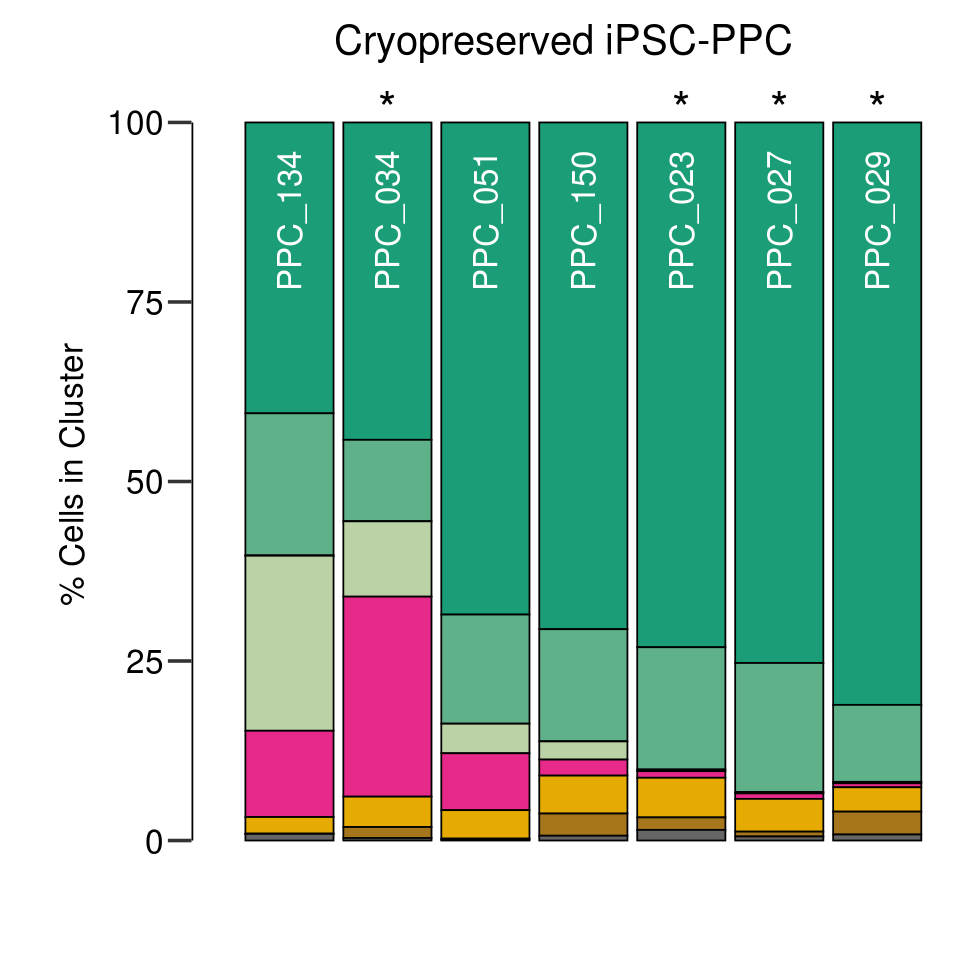

In [428]:
toplot = as.data.frame(rbindlist(lapply(unique(ppc2@meta.data[ppc2@meta.data$sample_type == "Cryo",]$type_udid), function(udid){
    this = ppc2@meta.data[ppc2@meta.data$type_udid == udid,]
    as.data.frame(rbindlist(lapply(cellmap$cluster, function(label){
        ncells = nrow(this[this$integrated_snn_res.0.08 == label,])
        data.frame(udid = udid, cluster = paste("Cluster", label), pct = ncells / nrow(this) * 100)
    })))
})))

cluster.order  = paste("Cluster", cellmap$cluster)

toplot$cluster = factor(toplot$cluster, levels = cluster.order)

col.order   = suppressMessages(mapvalues(cluster.order, from = paste("Cluster", cellmap$cluster), to = cellmap$color))
udid.order  = (toplot[toplot$cluster %like% "Cluster 0",] %>% arrange(pct))$udid

toplot$udid = factor(toplot$udid, levels = unique(udid.order))

psize(w = 8, h = 8)
cryo.barplot = ggplot(toplot, aes(x = udid, y = pct, fill = cluster, label = udid)) + geom_bar(stat = "identity", color = "black") + 
    scale_fill_manual(values = col.order, name = "", 
                      labels = c("Cluster 0" = "NKX6-1+", 
                                 "Cluster 1" = "Rep. NKX6-1+", 
                                 "Cluster 2" = "iPSC", 
                                 "Cluster 3" = "PDX1+", 
                                 "Cluster 4" = "Mes.", 
                                 "Cluster 5" = "E.Def.Endo.", 
                                 "Cluster 6" = "Endo.", 
                                 "Cluster 7" = "E.Ductal")) + 
    jn_theme + theme(axis.text.x = element_text(angle = 90, vjust = 0, hjust = 1)) + 
    xlab("") + ylab("% Cells in Cluster") + 
    theme(panel.border = element_blank(), axis.ticks.x = element_blank(), axis.ticks.y = element_line(size = 1)) +
    annotate("text", x = 1, y = 96, label = "PPC_134", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 2, y = 96, label = "PPC_034", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 3, y = 96, label = "PPC_051", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 4, y = 96, label = "PPC_150", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 5, y = 96, label = "PPC_023", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 6, y = 96, label = "PPC_027", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    annotate("text", x = 7, y = 96, label = "PPC_029", angle = 90, hjust = 1, size = 7, color = "#ffffff") +
    ggtitle("Cryopreserved iPSC-PPC") + theme(plot.title = element_text(hjust = 0.5), legend.position = "none", axis.text.x = element_blank()) +
    annotate("text", x = 2, y = 102, label = "*", size = 10) + 
    annotate("text", x = 5, y = 102, label = "*", size = 10) + 
    annotate("text", x = 6, y = 102, label = "*", size = 10) + 
    annotate("text", x = 7, y = 102, label = "*", size = 10) +
    annotate("segment", x = 0, xend = 0, y = 0, yend = 100, size = 1)

cryo.barplot

In [433]:
toplot = as.data.frame(rbindlist(lapply(unique(ppc2@meta.data$type_udid), function(udid){
    this = ppc2@meta.data[ppc2@meta.data$type_udid == udid,]
    as.data.frame(rbindlist(lapply(unique(ppc2@meta.data$cell), function(label){
        ncells = nrow(this[this$cell == label,])
        data.frame(udid = udid, cluster = label, pct = ncells / nrow(this) * 100)
    })))
})))

fwrite(toplot, "manuscript/LiveCryo.pct_cells.txt", row.names = F, sep = "\t")

head(toplot,2)

# Filter late PPC
toplot = toplot %>% filter(!udid %like% "iPSC") 

toplot$ppc_udid   = unlist(lapply(toplot$udid, function(x) { unlist(strsplit(x, "[.]"))[2] }))
toplot$pdx1_nkx61 = as.double(suppressMessages(mapvalues(toplot$ppc_udid, from = ppc2@meta.data$udid, to = ppc2@meta.data$pdx1_nkx61)))

plt_list = list()

for (cell in c("Late PPC", "Early PPC", "Mesendoderm", "Endocrine"))
{
    live = toplot %>% filter(cluster == cell & udid %like% "Live")
    cryo = toplot %>% filter(cluster == cell & udid %like% "Cryo")

    toplot2 = merge(live, cryo, by = c("cluster", "ppc_udid", "pdx1_nkx61"), suffixes = c(".live", ".cryo"))

    mylm   = lm(toplot2$pct.live ~ toplot2$pct.cryo)
    mycor  = cor.test(toplot2$pct.live, toplot2$pct.cryo)

    p = ggplot(toplot2, aes(x = pct.cryo, y = pct.live, color = ppc_udid, label = ppc_udid)) +
        geom_point(size = 7) + jn_theme +
        NoLegend() + geom_text_repel(size = 7) +
        scale_color_manual(values = colPanel) +
        geom_abline(intercept = mylm$coefficients[1], slope = mylm$coefficients[2]) + theme(plot.title = element_text(size = 15)) +
        geom_text(aes(x = -Inf, y = Inf), label = paste0("p=", signif(mycor$p.value,3)) , hjust = -0.18, vjust = 5.6, size = 8, color = "black", fontface = "plain") +
        xlab("Cryopreserved") + ylab("Fresh")

    if (cell == "Mesendoderm")
    {
        p = p + geom_text(aes(x = -Inf, y = Inf), label = cell, hjust = -0.12, vjust = 2  , size = 8, color = "black") 
    } else 
    {
        p = p + geom_text(aes(x = -Inf, y = Inf), label = cell, hjust = -0.19, vjust = 2  , size = 8, color = "black") 
    }
    
    if (signif(mycor$estimate,3) == 1)
    {
        p = p + geom_text(aes(x = -Inf, y = Inf), label = paste0("R=", signif(mycor$estimate,3)), hjust = -0.58, vjust = 3.8, size = 8, color = "black", fontface = "plain") 
    } else 
    {
        p = p + geom_text(aes(x = -Inf, y = Inf), label = paste0("R=", signif(mycor$estimate,3)), hjust = -0.2, vjust = 3.8, size = 8, color = "black", fontface = "plain") 
    }
    
    plt_list[[cell]] = p
}


,udid,cluster,pct
,<chr>,<chr>,<dbl>
1,Cryo.PPC_034,Late PPC,44.19552
2,Cryo.PPC_034,Rep. Late PPC,11.35438


In [434]:
psize(w = 35, h = 7)
g1 = plot_grid(NULL, live.barplot, cryo.barplot, NULL, nrow = 1, labels = c("", "A", "B", ""), label_size = 33, rel_widths = c(0.7, 1, 1, 0.7))
g2 = plot_grid(plotlist = plt_list, nrow = 1, labels = c("C", "D", "E", "F"), label_size = 33)

g = plot_grid(g1, g2, ncol = 1)

png("manuscript/live_cryo.png", width = 2100, height = 1200)
g
dev.off()

png 
  2

# FACS

In [616]:
# snatac_meta = fread("tables/snatac_meta.txt", data.table = F)
# snatac_meta[snatac_meta$celltype == "NKX6-1+ Progenitors", "celltype"] = "Late PPC"

# load("manuscript/snatac_filt.robj", verbose = T)
snatac_meta = subset@meta.data


In [617]:
scrna_meta = ppc2@meta.data

In [618]:
cellmap2 = data.frame(cluster   = c(0:8),
                     rna.cell  = c("Late PPC", "Rep. Late PPC", "iPSC", "Early PPC", "Mesendoderm", "Early DE", "Endocrine", "Early Ductal", "NA"),
                     color     = c("#1B9E77", "#5fb189", "#7570B3", "#bbd2a6", "#E7298A", "#E6AB02", "#A6761D", "#666666", NA),
                     atac.cell = c("Late PPC 2", "Late PPC 1", "Rep. Late PPC", "Early DE", "Mesendoderm", "Early PPC", "Early Endocrine", "Endocrine", "Early Ductal"))

# cellmap2$atac.color = unlist(lapply(cellmap2$atac.cell, function(x) { cols[[x]] }))
cellmap2

snatac_meta$cell = suppressMessages(mapvalues(snatac_meta$integrated_snn_res.0.6, from = cellmap2$cluster, to = cellmap2$atac.cell))

unique(snatac_meta$cell)

cluster,rna.cell,color,atac.cell
<int>,<chr>,<chr>,<chr>
0,Late PPC,#1B9E77,Late PPC 2
1,Rep. Late PPC,#5fb189,Late PPC 1
2,iPSC,#7570B3,Rep. Late PPC
3,Early PPC,#bbd2a6,Early DE
4,Mesendoderm,#E7298A,Mesendoderm
5,Early DE,#E6AB02,Early PPC
6,Endocrine,#A6761D,Early Endocrine
7,Early Ductal,#666666,Endocrine
8,NA,NA,Early Ductal


[1] Late PPC 2      Rep. Late PPC   Early PPC       Endocrine      
[5] Early DE        Early Endocrine Mesendoderm     Late PPC 1     
[9] Early Ductal   
10 Levels: Late PPC 2 Late PPC 1 Rep. Late PPC Early DE ... 9

udid,pct_nkx.rna,pct_nkx.atac
<chr>,<dbl>,<dbl>
PPC_027,95.58615,97.44898
PPC_150,88.72768,93.05776
PPC_051,87.84762,85.20984
PPC_134,84.67462,71.50000
PPC_029,93.32578,95.72895
PPC_023,94.13010,96.05400
PPC_034,85.01308,71.12069


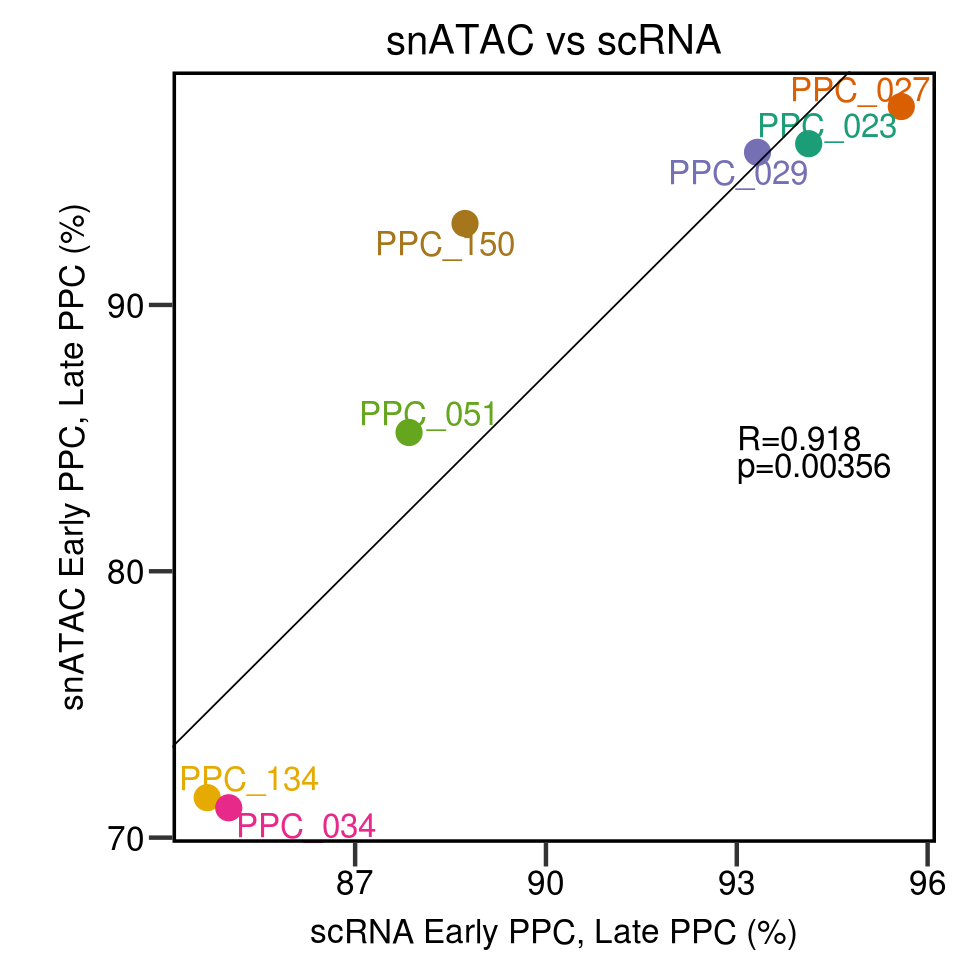

In [626]:
toplot = as.data.frame(rbindlist(lapply(overlapping_udid, function(udid){

    this_rna  =  scrna_meta[ scrna_meta$udid == udid,]
    this_atac = snatac_meta[snatac_meta$udid == udid,] 

    total_rna  = nrow(this_rna)
    total_atac = nrow(this_atac)

    rna_nkx = nrow(this_rna[this_rna$cell %in% c("Late PPC", "Early PPC", "Rep. Late PPC"),])
    atac_nkx = nrow(this_atac[this_atac$cell %like% "PPC",])

    data.frame(udid = udid, pct_nkx.rna = (rna_nkx / total_rna) * 100, pct_nkx.atac = (atac_nkx / total_atac) * 100)
})))

toplot

mylm = lm(toplot$pct_nkx.atac ~ toplot$pct_nkx.rna)
mycor = cor.test(toplot$pct_nkx.atac, toplot$pct_nkx.rna)

psize(w = 8, h = 8)
scrna_snatac = ggplot(toplot, aes(x = pct_nkx.rna, y = pct_nkx.atac, color = udid, label = udid)) + geom_point(size = 7) +
    geom_text_repel(size = 7) + jn_theme + 
    scale_color_manual(values = colPanel)  +
    theme(legend.position = "none") + 
    geom_abline(intercept = mylm$coefficients[1], slope = mylm$coefficients[2]) + 
    annotate("text", x = 93, y = 85, label = paste0("R=", signif(mycor$estimate,3)), size = 7, hjust = 0) +
    annotate("text", x = 93, y = 84, label = paste0("p=", signif(mycor$p.value,3)), size = 7, hjust = 0) + 
    xlab("scRNA Early PPC, Late PPC (%)") + ylab("snATAC Early PPC, Late PPC (%)") +
    ggtitle("snATAC vs scRNA") + theme(plot.title = element_text(hjust = 0.5))

scrna_snatac

udid,cluster,pct,pdx1_nkx61
<chr>,<chr>,<dbl>,<dbl>
PPC_034,Late PPC,79.97384,71.2
PPC_029,Late PPC,93.25368,70.7
PPC_134,Late PPC,60.30035,14.6
PPC_023,Late PPC,94.05387,91.7
PPC_027,Late PPC,95.52774,75.8
PPC_150,Late PPC,86.19792,59.0
PPC_051,Late PPC,83.73333,50.8
PPC_028,Late PPC,1.91299,9.4
PPC_030,Late PPC,94.57478,80.3


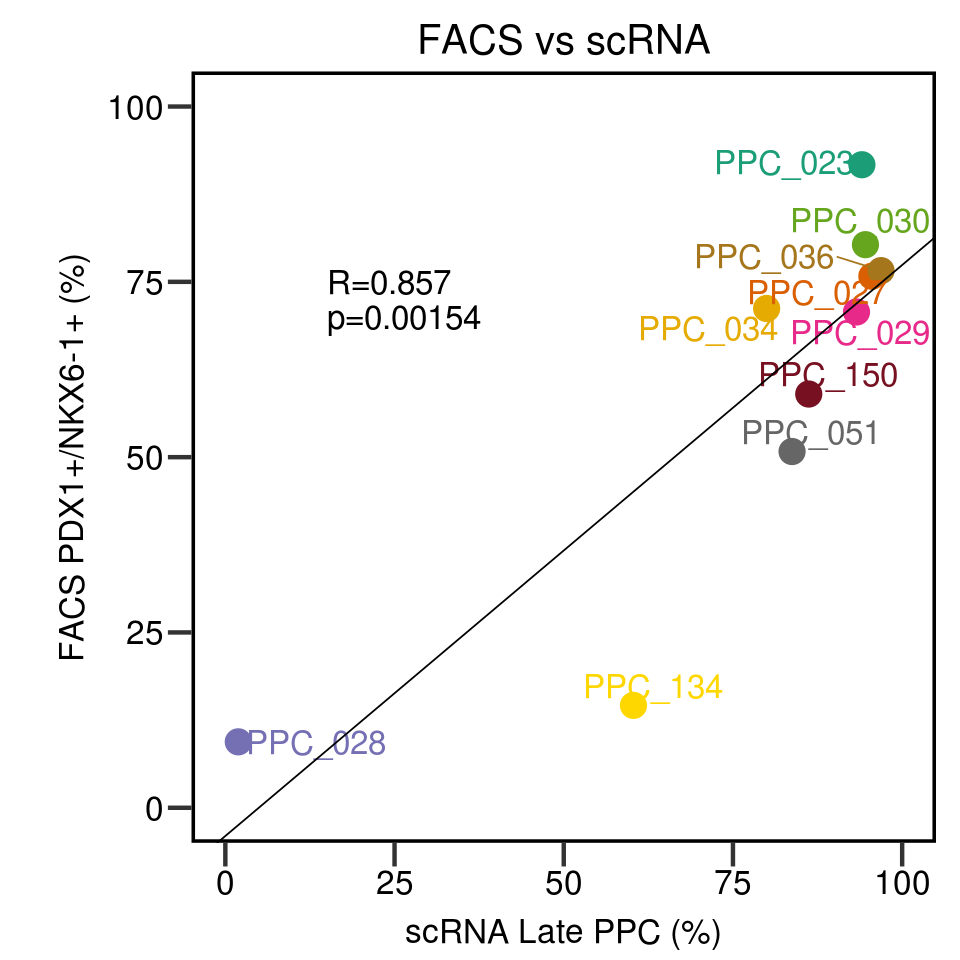

In [627]:
toplot = fread("manuscript/udid.pct_cells.txt", data.table = F) %>% filter(cluster %like% "Late PPC" & udid != "iPSC-PPC_034") 
toplot$pdx1_nkx61 = as.double(suppressMessages(mapvalues(toplot$udid, from = ppc2@meta.data$udid, to = ppc2@meta.data$pdx1_nkx61)))

toplot = as.data.frame(rbindlist(lapply(unique(toplot$udid), function(x)
{
    this = toplot %>% filter(udid == x)
    data.frame(udid = x, cluster = "Late PPC", pct = sum(this$pct), pdx1_nkx61 = unique(this$pdx1_nkx61))
})))

toplot

mylm = lm(toplot$pdx1_nkx61 ~ toplot$pct)
mycor = cor.test(toplot$pct, toplot$pdx1_nkx61)

facs_scrna = ggplot(toplot, aes(x = pct, y = pdx1_nkx61, color = udid, label = udid)) + geom_point(size = 7) + 
    geom_text_repel(size = 7) + jn_theme + 
    scale_color_manual(values = colPanel)  +
    theme(legend.position = "none") + 
    geom_abline(intercept = mylm$coefficients[1], slope = mylm$coefficients[2]) + 
    annotate("text", x = 15, y = 75, label = paste0("R=", signif(mycor$estimate,3)), size = 7, hjust = 0) + 
    annotate("text", x = 15, y = 70, label = paste0("p=", signif(mycor$p.value,3)), size = 7, hjust = 0) + 
    xlab("scRNA Late PPC (%)") + ylab("FACS PDX1+/NKX6-1+ (%)") +
    ggtitle("FACS vs scRNA") + theme(plot.title = element_text(hjust = 0.5)) +
    xlim(0,100) + ylim(0,100) 

facs_scrna

In [628]:
png("manuscript/facs_scrna_snatac.png", width = 1300, height = 700)
plot_grid(facs_scrna, scrna_snatac, nrow = 1, labels = "AUTO", label_size = 30)
dev.off()

png 
  2

# UMAP

In [518]:
unique(ppc2@meta.data$cell)
cellmap

[1] "Late PPC"      "Rep. Late PPC" "Early PPC"     "Mesendoderm"  
[5] "Early DE"      "Endocrine"     "Early Ductal"  "iPSC"

cluster,rna.cell,color
<int>,<chr>,<chr>
0,Late PPC,#1B9E77
1,Rep. Late PPC,#5fb189
2,iPSC,#7570B3
3,Early PPC,#bbd2a6
4,Mesendoderm,#E7298A
5,Early DE,#E6AB02
6,Endocrine,#A6761D
7,Early Ductal,#666666


In [14]:
ppc2@meta.data[,c("UMAP_1", "UMAP_2")] = NULL
ppc2@meta.data = add_rownames(merge(ppc2@meta.data, Embeddings(ppc2, "umap"), by = "row.names"))

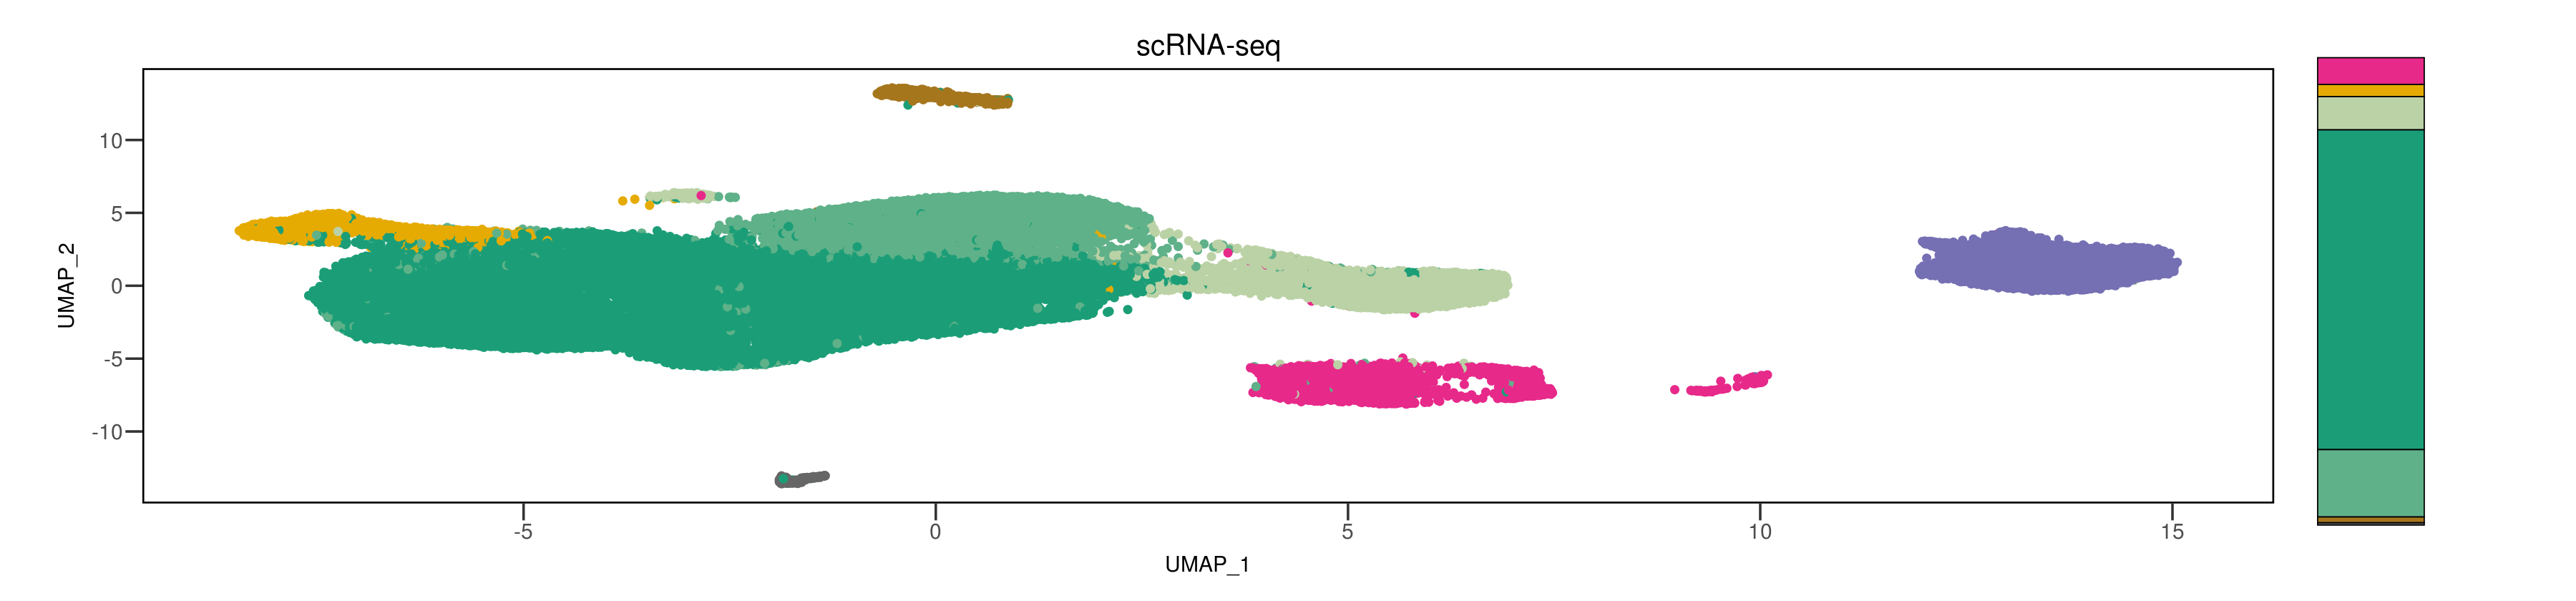

In [15]:
cluster.order = c("iPSC", "Mesendoderm", "Early DE", "Early PPC", "Late PPC", 'Rep. Late PPC', "Endocrine", "Early Ductal")

p = PlotUMAP(ppc2@meta.data, "cell", NA, "UMAP_1", "UMAP_2", cellmap, cluster.order, "rna.cell", "color") + 
    theme(legend.title = element_blank(),
          legend.position = "bottom",
          panel.border = element_rect(color = "black", fill = NA, size = 1.5),
          plot.title = element_text(hjust = 0.5), 
          legend.text = element_text(size = 20),
          axis.text = element_text(size = 18), 
          axis.title = element_text(size = 18), 
          plot.margin = margin(r = 2, l = 2, t = 1, b = 1, unit = "cm"),
          axis.ticks = element_line(size = 1)
         ) + 
    guides(color = guide_legend(nrow = 2, override.aes = list(size = 10))) +
    xlab("UMAP_1") + ylab("UMAP_2") + ggtitle("scRNA-seq") 

ppc2@meta.data$cell = as.vector(ppc2@meta.data$cell)

tobar = data.frame(table(ppc2@meta.data[!ppc2@meta.data$cell %like% "iPSC",]$cell)) %>% mutate(pct = (Freq / sum(Freq)) * 100)
tobar$Var1 = factor(tobar$Var1, levels = cluster.order)
cols = suppressMessages(mapvalues(cluster.order[which(cluster.order != "iPSC")], from = cellmap$rna.cell, to = cellmap$color))

bar2 = ggplot(tobar, aes(x = "", y = pct, fill = Var1)) + geom_bar(stat = "identity", color = "black") + jn_theme + 
    theme(
        panel.border = element_blank(),
        axis.ticks = element_blank(),
        axis.text = element_blank(),
        plot.title = element_text(hjust = 0.5),
        legend.position = "none",
        plot.margin = margin(r = 0.5, l = -2.5, t = 0, b = 0, unit = "cm"),
        title = element_text(vjust = 3),
        axis.title.x = element_text(size = 17, margin=margin(b = 0.5, unit = "cm"))
    ) + xlab("") + ylab("") + 
    scale_fill_manual(values = cols)  + ggtitle("")

library(ggplotify)
rna_legend = as.ggplot(get_legend(p))

p = p + theme(legend.position = "none")
grid = plot_grid(p, bar2, ncol = 3, rel_widths = c(1, 0.05, 0.05))

grid



In [16]:
rna_grid = plot_grid(grid, rna.bar, labels = c("A", "C"), label_size = 33, nrow = 1, rel_widths = c(1, 0.8))
rna_grid = plot_grid(rna_grid, rna_legend, ncol = 1, rel_heights = c(1, 0.15))

save(rna_grid, file = paste("manuscript", "rna_grid.robj", sep = "/"))

In [5]:
load(paste("manuscript", "rna_grid.robj", sep = "/"), verbose = T)

Loading objects:
  rna_grid


In [7]:
load("manuscript/atac_grid.robj", verbose = T)
load("manuscript/atac.heatmap.robj", verbose = T)

Loading objects:
  atac_grid
Loading objects:
  atac.heatmap


In [8]:
psize(w = 30, h = 7)
umaps = plot_grid(rna_grid, atac_grid, nrow = 1)
umaps

ERROR while rich displaying an object: Error in validGP(gp): must specify only one of 'font' and 'fontface'

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(captu

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

In [22]:
heats = plot_grid(rna_heat, atac.heatmap + theme(plot.margin = margin(l = 5,t = 0.5, unit = "cm")), nrow = 1, labels = c("B", "E"), label_size = 33)

In [23]:
png("manuscript/figure2.png", height = 1200, width = 2000)
plot_grid(umaps, NULL, heats, ncol = 1, rel_heights = c(0.7, 0.1, 0.8))
dev.off()

png 
  2

In [75]:
a = ppc2@meta.data %>% filter(udid == "PPC_034")
data.frame(table(a$cell) / nrow(a) * 100)
62.7201395 + 17.2537053



Var1,Freq
<fct>,<dbl>
Early DE,1.8308631
Early Ductal,0.3051439
Early PPC,5.0392328
Endocrine,1.0985179
Late PPC,62.7201395
Mesendoderm,11.7523976
Rep. Late PPC,17.2537053


[1] 79.97384

Var1,total
<fct>,<dbl>
PPC_036,96.88844
PPC_027,95.58615
PPC_030,94.95827
PPC_023,94.13010
PPC_029,93.32578
PPC_150,88.72768
PPC_051,87.84762
PPC_034,85.01308
PPC_134,84.67462


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  63.10   85.72   91.03   88.42   94.75   96.89 


	Pearson's product-moment correlation

data:  c$pct.x and c$pct.y
t = 111.01, df = 6, p-value = 3.602e-11
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9985962 0.9999578
sample estimates:
      cor 
0.9997567 


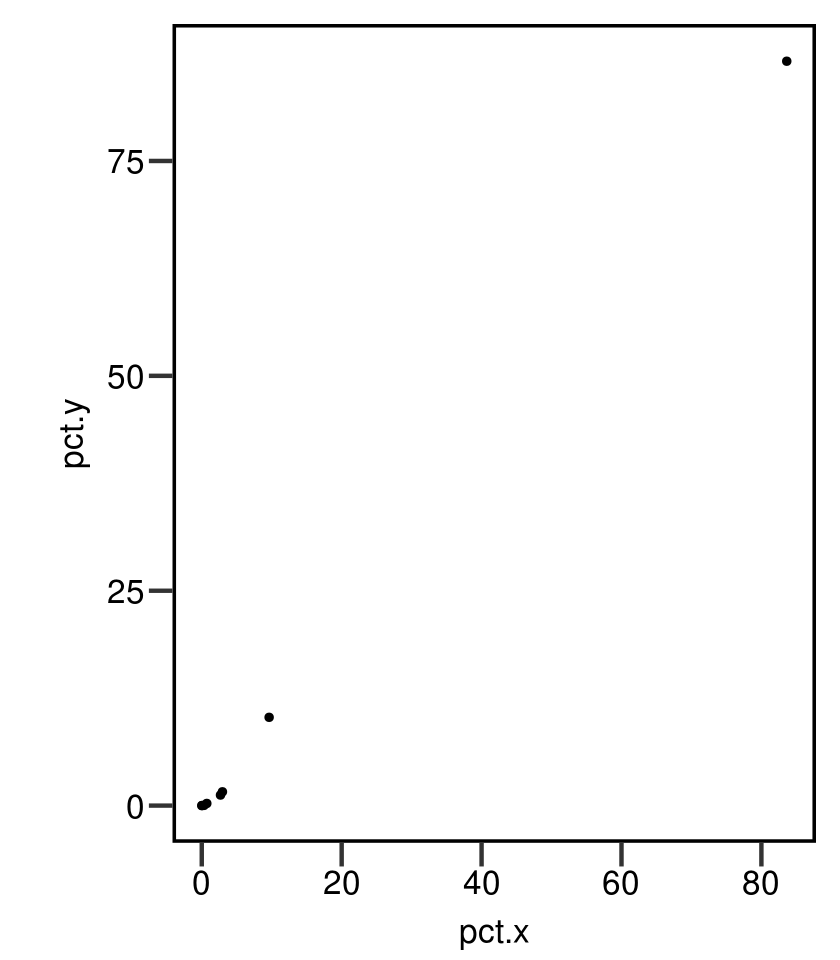

In [63]:
a = data.frame(table(ppc2@meta.data$udid, ppc2@meta.data$cell)) %>% mutate(Var2 = as.character(Var2)) %>% 
    group_by(Var1) %>% 
    dplyr::mutate(total = sum(Freq)) %>% 
    mutate(pct = Freq / total * 100) %>%
    filter(Var2 %like% "PPC" & Var1 != "iPSC-PPC_034") %>%
    dplyr::summarise(total = sum(pct)) %>%
    arrange(desc(total)) 

a

summary(a$total)

a = data.frame(table(ppc2@meta.data$udid, ppc2@meta.data$cell)) %>% mutate(Var2 = as.character(Var2)) %>% 
    group_by(Var1) %>% 
    dplyr::mutate(total = sum(Freq)) %>% 
    mutate(pct = Freq / total * 100) %>%
    filter(Var1 %in% c("PPC_029"))

b = data.frame(table(ppc2@meta.data$udid, ppc2@meta.data$cell)) %>% mutate(Var2 = as.character(Var2)) %>% 
    group_by(Var1) %>% 
    dplyr::mutate(total = sum(Freq)) %>% 
    mutate(pct = Freq / total * 100) %>%
    filter(Var1 %in% c("PPC_036"))

c = merge(a[,c("Var2", "pct")], b[,c("Var2", "pct")], by = c("Var2"))

cor.test(c$pct.x, c$pct.y)

options(repr.plot.height = 8, repr.plot.width = 7)
ggplot(c, aes(x = pct.x, y = pct.y)) + geom_point(size = 2) + jn_theme